# 13. Creating a pipeline

In the previous chapter we created a procedure to isolate nuclei from images. Very often the goal is to repeat the exercise on multiple images in order to compare different conditions. Here we are going to see how to package our pipeline into a function, how to apply it to multiple images and how to plot the result for comparison. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.morphology

## 13.1 Creating an image processing function

We have seen previously how to define a function. It needs the ```def``` descriptor, a name and inputs. What we are doing here is just copying all the lines that we used for our pipeline in the last chapter into this function. At the moment the only input is the path to a given file to analyze:

In [2]:
#this function extracts nuclei from the third channel of an image stack
#parameters:
# - image_path: string, path to a file
#
#output: Pandas dataframe with parameters describing each nucleus
def my_pipeline(image_path):
    image_stack = skimage.io.imread(image_path)
    image_nuclei = image_stack[:,:,2]
    mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
    my_labels = skimage.morphology.label(mask_nuclei)
    my_regions = skimage.measure.regionprops(my_labels,intensity_image=image_stack[:,:,1])
    
    plt.subplots(figsize=(10,10))
    plt.imshow(mask_nuclei)
    plt.show()
    
    my_values = []
    
    for elem in my_regions:
        current_dict = {'area': elem.area, 'intensity': elem.mean_intensity, 'extent': elem.major_axis_length}
        my_values.append(current_dict)
        
    my_table = pd.DataFrame(my_values)
    
    return my_table
                
                

We can now test our function with a single image:

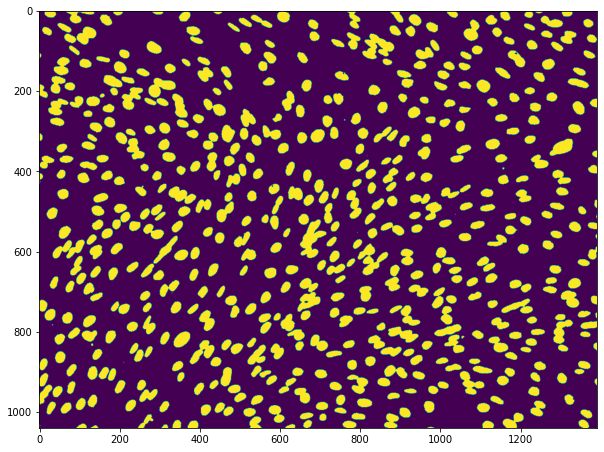

In [3]:
table = my_pipeline('https://cildata.crbs.ucsd.edu/media/images/13585/13585.tif')
#table = my_pipeline('../Data/myoblast.tif')


In [4]:
table

,area,intensity,extent
0,5,36.000000,5.656854
1,394,33.553299,29.805083
2,978,52.586912,67.452921
3,217,32.119816,25.418682
4,204,32.284314,28.546847
...,...,...,...
538,202,33.465347,24.961502
539,181,36.198895,25.470028
540,110,35.200000,15.734180
541,84,33.833333,17.444368


## 13.2 Adjusting the function behavior

We have recovered the same result as previously and can analyze again our data as we did before. The mask is also plotted by default when calling the function. This is helpful to test the function and verify that nothing went dramatically wrong but we probably don't want to see this image if we analyze hundreds of images. What we can do is leave the user the choice to see it or not. Let's adjust our function to do that: we add an additional **optional** parameter which is simply a boolean (True/False). If True, plotting is happening, if False it's not.

In [5]:
#this function extracts nuclei from the third channel of an image stack
#parameters:
# - image_path: string, path to a file
# - do_plotting: boolean, plot the maks or not
#
#output: Pandas dataframe with parameters describing each nucleus
def my_pipeline(image_path, do_plotting = False):
    image_stack = skimage.io.imread(image_path)
    image_nuclei = image_stack[:,:,2]
    mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
    my_labels = skimage.morphology.label(mask_nuclei)
    my_regions = skimage.measure.regionprops(my_labels,intensity_image=image_stack[:,:,1])
    
    if do_plotting:
        plt.subplots(figsize=(10,10))
        plt.imshow(mask_nuclei)
        plt.show()
    
    my_values = []
    
    for elem in my_regions:
        current_dict = {'area': elem.area, 'intensity': elem.mean_intensity, 'extent': elem.major_axis_length}
        my_values.append(current_dict)
        
    my_table = pd.DataFrame(my_values)
    
    return my_table
                
                

In [6]:
table = my_pipeline('https://cildata.crbs.ucsd.edu/media/images/13585/13585.tif')
#table = my_pipeline('../Data/myoblast.tif')

Now indeed our function doesn't produce any output if we don't explicitly ask for it. 

## 13.3 Analyzing multiple images 

The point of creating an image processing pipeline was to be able to easily analyze multiple images. We can do that now by using a simple for loop. First we create a list of files we want to analyze and that we can see [here](http://flagella.crbs.ucsd.edu/images/13601) and [here](http://flagella.crbs.ucsd.edu/images/13585).

In [11]:
files_to_analyze = ['https://cildata.crbs.ucsd.edu/media/images/13585/13585.tif', 'https://cildata.crbs.ucsd.edu/media/images/13601/13601.tif']
#files_to_analyze = ['../Data/myoblast2.tif', '../Data/myoblast3.tif']

Now we create a for loop that will go through this list of files and analyze each of them with our function. As we did previously, before the loop, we create an empty list that is going to be filled with the output of the function: 

In [12]:
all_tables = []
for file in files_to_analyze:
    
    #use the function
    new_table = my_pipeline(file)
    
    #append the result to the list
    all_tables.append(new_table)
    

Let's verify what we really have in that list:

In [13]:
all_tables[1]

,area,intensity,extent
0,64,0.000000,13.826750
1,180,0.800000,23.934542
2,276,0.000000,28.955820
3,242,22.723140,23.691617
4,185,0.000000,29.234774
...,...,...,...
544,136,0.044118,15.674292
545,134,98.201493,18.172646
546,54,0.166667,9.493249
547,51,2.470588,10.857129


We can of course again plot all our results. However now we have two conditions, so we can compare them by plotting them together:

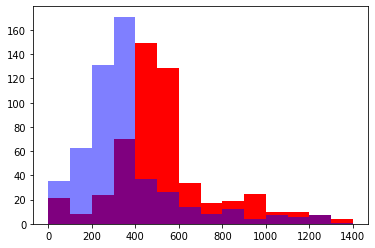

In [14]:
plt.hist(all_tables[0].area, bins = np.arange(0,1500,100), color = 'red')
plt.hist(all_tables[1].area, bins = np.arange(0,1500,100), alpha = 0.5, color = 'blue')
plt.show()

Our visual impression is confirmed! Nuclei in the second condition are indeed smaller than in the first one, and now we can "prove" it!